In [1]:
import sys

sys.path.append(r"../src")

from datasets.HMNIST import HealingMNIST

import os
import numpy as np
import matplotlib.pyplot as plt

os.chdir(r"../")
os.getcwd()

'C:\\Developments\\New folder\\VAEImputer'

# Loading Data

In [2]:
hmnist_dataset = HealingMNIST(download_dir="data\\HMNIST",
                              download_url="https://www.dropbox.com/s/xzhelx89bzpkkvq/hmnist_mnar.npz?dl=1",
                              file_name="hmnist_mnar.npz",
                              validation_split=50_000,
                              batch_size=2000,
                              num_workers=4)

hmnist_dataset.setup()

train_data = hmnist_dataset.train_dataloader()
test_data = hmnist_dataset.test_dataloader()

In [3]:
# The mask is for existing data, True existing False is missing

train_full, train_miss, train_mask, y_train = train_data.dataset.tensors

test_full, test_miss, test_mask, y_test = test_data.dataset.tensors

In [4]:
# total missing data
(~test_mask).sum()

tensor(35527674)

In [5]:
print("train shape" ,train_miss.shape)
print("test shape", test_miss.shape)

train shape torch.Size([60000, 10, 784])
test shape torch.Size([10000, 10, 784])


In [6]:
train_miss = np.where(train_mask == True, train_miss, np.nan)
test_miss = np.where(test_mask == True, test_miss, np.nan)

In [6]:
image_shape = (28, 28, 1)

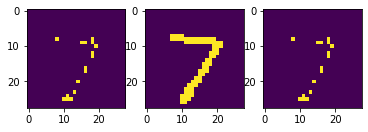

In [7]:
f, axs = plt.subplots(1,3)
axs[0].imshow(test_miss[0, 0].reshape(image_shape))
axs[1].imshow(test_full[0, 0].reshape(image_shape))
axs[2].imshow(np.where(test_mask[0,0] == 1, test_full[0, 0], 0).reshape(image_shape))

plt.show()

In [34]:
train_miss.permute(0, 2, 1).shape

torch.Size([60000, 784, 10])

In [42]:
import torch

In [49]:
train_miss.permute(0, 2, 1).shape

torch.Size([60000, 784, 10])

In [57]:
torch.tile(train_miss.permute(0, 2, 1).mean(2).unsqueeze(1), [1, 10, 1]).permute(0, 2, 1)

torch.Size([60000, 784, 10])

In [61]:
train_imputed_mean = torch.where(train_miss.permute(0, 2, 1) == np.nan,
                                 torch.tile(train_miss.permute(0, 2, 1).mean(2).unsqueeze(1), [1, 10, 1]).permute(0, 2, 1),
                                 train_miss.permute(0, 2, 1))

In [65]:
train_imputed_mean = train_imputed_mean.permute(0, 2, 1).reshape(-1, 784)

In [8]:
X_train = train_miss.reshape(60_000, 10 * 28 * 28)
X_test = test_miss.reshape(10_000, 10 * 28 * 28)

In [9]:
print(X_train.shape)
np.unique(X_train)

(60000, 7840)


array([ 0.,  1., nan], dtype=float32)

In [10]:
print(X_test.shape)
np.unique(X_test)

(10000, 7840)


array([ 0.,  1., nan], dtype=float32)

# Training

In [69]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.metrics import mean_squared_error

def compute_mse_auroc(X, y, X_full, X_mask, split=5000, num_classes=10):
    
    # mse over missing data
    mse = mean_squared_error(X_full.reshape(-1),\
                   X.reshape(-1),\
                   sample_weight=(~X_mask).reshape(-1))

    print(f"MSE: {mse:.3f}")
    X = np.round(X)
    clf = LogisticRegression(solver='lbfgs', multi_class='multinomial', tol=1e-10, max_iter=10000)
    clf.fit(X[:split], y[:split])
    probs = clf.predict_proba(X[split:])
    
    auprc = average_precision_score(np.eye(num_classes)[y[5000:]], probs)
    auroc = roc_auc_score(np.eye(num_classes)[y[5000:]], probs)
    print("AUROC: {:.3f}".format(auroc))
    print("AUPRC: {:.3f}".format(auprc))
    
def squared_difference(input, target):
    return (input - target) ** 2

# Full Data

In [31]:
X_test_full = test_full.reshape(10_000, 10 * 28 * 28)

In [32]:
compute_mse_auroc(X_test_full, y_test, test_full, test_mask)

MSE: 0.000
AUROC: 0.966
AUPRC: 0.847


# Fill 0 imputation

In [12]:
X_test_miss = np.where(test_mask == 1, test_full, 0).reshape(10_000, 10 * 28 * 28)

In [13]:
compute_mse_auroc(X_test_miss, y_test, test_full, test_mask)

MSE: 0.234
AUROC: 0.920
AUPRC: 0.666


## Mean Imputation

In [70]:
train_imputed_mean
compute_mse_auroc(train_imputed_mean, y_train, train_full, train_mask)

MSE: 0.232


ValueError: Found input variables with inconsistent numbers of samples: [55000, 595000]

In [14]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

In [15]:
X_train.shape

(60000, 7840)

In [16]:
X_train_mean = imputer.fit_transform(X_train)

X_test_mean = imputer.transform(X_test)

In [17]:
compute_mse_auroc(X_test_mean, y_test, test_full, test_mask)

MSE: 0.178
AUROC: 0.920
AUPRC: 0.666


In [18]:
compute_mse_auroc(np.round(X_test_mean), y_test, test_full, test_mask)

MSE: 0.234
AUROC: 0.920
AUPRC: 0.666


## Forward Imputation

In [19]:
# ffill along axis 1, as provided in the answer by Divakar
def ffill(arr):
    mask = np.isnan(arr)
    idx = np.where(~mask, np.arange(mask.shape[1]), 0)
    np.maximum.accumulate(idx, axis=1, out=idx)
    out = arr[np.arange(idx.shape[0])[:,None], idx]
    return out

# Simple solution for bfill provided by financial_physician in comment below
def bfill(arr): 
    return ffill(arr[:, ::-1])[:, ::-1]

In [28]:
X_test_forward = bfill(ffill(X_test.reshape(10_000 * 280, 28)))
X_test_forward = X_test_forward.reshape(10_000, -1)
X_test_forward.shape

(10000, 7840)

In [29]:
compute_mse_auroc(X_test_forward, y_test, test_full, test_mask)

MSE: 0.179
AUROC: 0.937
AUPRC: 0.727


## Data Validation

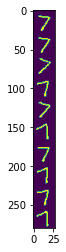

In [11]:
X = test_full.reshape(10_000, 280, 28)
plt.imshow(X[0])

In [9]:
X_test = X_test.reshape(10_000, 280, 28)
plt.imshow(X_test[0])

NameError: name 'X_test' is not defined

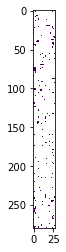

In [12]:
X = test_m.reshape(10_000, 280, 28)
plt.imshow(X[0])